In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,StratifiedKFold, cross_val_score, train_test_split
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

In [71]:
#read data scikit-learn
os.chdir('C:/Users/Katharina/Desktop/Weiterbildung/Bootcamp/Bootcamp/Final_project/data')
data = pd.read_csv('DatenML_V2_relCol.csv', sep=';')

In [72]:
data.columns

Index(['Gender_x', 'SpikeFault', 'SpikePoint', 'ServeFault', 'ServePoint',
       'ServeTotal', 'BlockPoint', 'BlockTotal', 'DigTotal', 'ReceptionFault',
       'SpikeTotal', '@LocalDate', '@LocalTime', 'FederationCode_y',
       'FirstName', 'LastName', 'TeamName', '@TeamAName', '@TeamBName',
       '@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
       '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3',
       '@DurationSet1', '@DurationSet2', '@DurationSet3', 'temperature_2m',
       'precipitation', 'wind_speed_10m', 'rain', 'wind_gusts_10m',
       'TeamFault_team', 'match_win', 'total_A', 'total_B', 'TeamDesignation'],
      dtype='object')

In [ ]:

import pandas as pd
import numpy as np


df = data
# Erstellen der neuen Spalte "Team1":
# Wenn TeamDesignation = A, dann soll TeamAName in Team1 stehen,
# andernfalls (also bei B) TeamBName.
df["Team1"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamAName"],
    df["@TeamBName"]
)

# Erstellen der Spalte "Team2" als das jeweils andere Team:
df["Team2"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamBName"],
    df["@TeamAName"]
)



In [ ]:
#bestimmte Variablen entfernen
data1 = data.drop(['FirstName', 'LastName','total_A', 'total_B', 'TeamDesignation','@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
       '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3', 
       'FederationCode_y', 'Gender_x','TeamName',
       '@DurationSet1','@LocalDate', '@LocalTime',
       '@DurationSet2', '@DurationSet3'], axis=1)


In [35]:
data1.columns

Index(['Gender_x', 'SpikeFault', 'SpikePoint', 'ServeFault', 'ServePoint',
       'ServeTotal', 'BlockPoint', 'BlockTotal', 'DigTotal', 'ReceptionFault',
       'SpikeTotal', '@LocalDate', '@LocalTime', 'TeamName', 'temperature_2m',
       'precipitation', 'wind_speed_10m', 'rain', 'wind_gusts_10m',
       'TeamFault_team'],
      dtype='object')

In [45]:
y = data1.pop('match_win')
X = data1.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [46]:
# select categorical and numerical column names
nominal_features = X.select_dtypes(include=['object']).columns.tolist()
# Define feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessors for different feature types
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Build the column transformer
transformers = [
    ('num', numeric_transformer, numeric_features),
    ('nom', nominal_transformer, nominal_features)
]

In [47]:
preprocessor = ColumnTransformer(transformers=transformers)

In [51]:
#Model Building
# Define models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2),
     'GradientBoosting': GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8)
}

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [41]:
# Function to train and evaluate models
def evaluate_model(name, model, X, y, cv):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    
    print(f"{name} - Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance
    pipeline.fit(X, y)
    
    return pipeline

In [52]:
# Evaluate all models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = evaluate_model(name, model, X, y, cv)
    trained_models[name] = pipeline


Training RandomForest...
RandomForest - Cross-validation Accuracy: 0.8505 (±0.0058)

Training GradientBoosting...
GradientBoosting - Cross-validation Accuracy: 0.8571 (±0.0082)



Top 20 most important features:
           Feature  Importance
4       ServeTotal    0.460669
0       SpikeFault    0.167074
9       SpikeTotal    0.104893
8   ReceptionFault    0.041722
15  TeamFault_team    0.040004
1       SpikePoint    0.035273
5       BlockPoint    0.024904
2       ServeFault    0.023396
6       BlockTotal    0.018502
3       ServePoint    0.017599
12  wind_speed_10m    0.016787
7         DigTotal    0.016150
10  temperature_2m    0.016124
14  wind_gusts_10m    0.013222
13            rain    0.002033
11   precipitation    0.001649


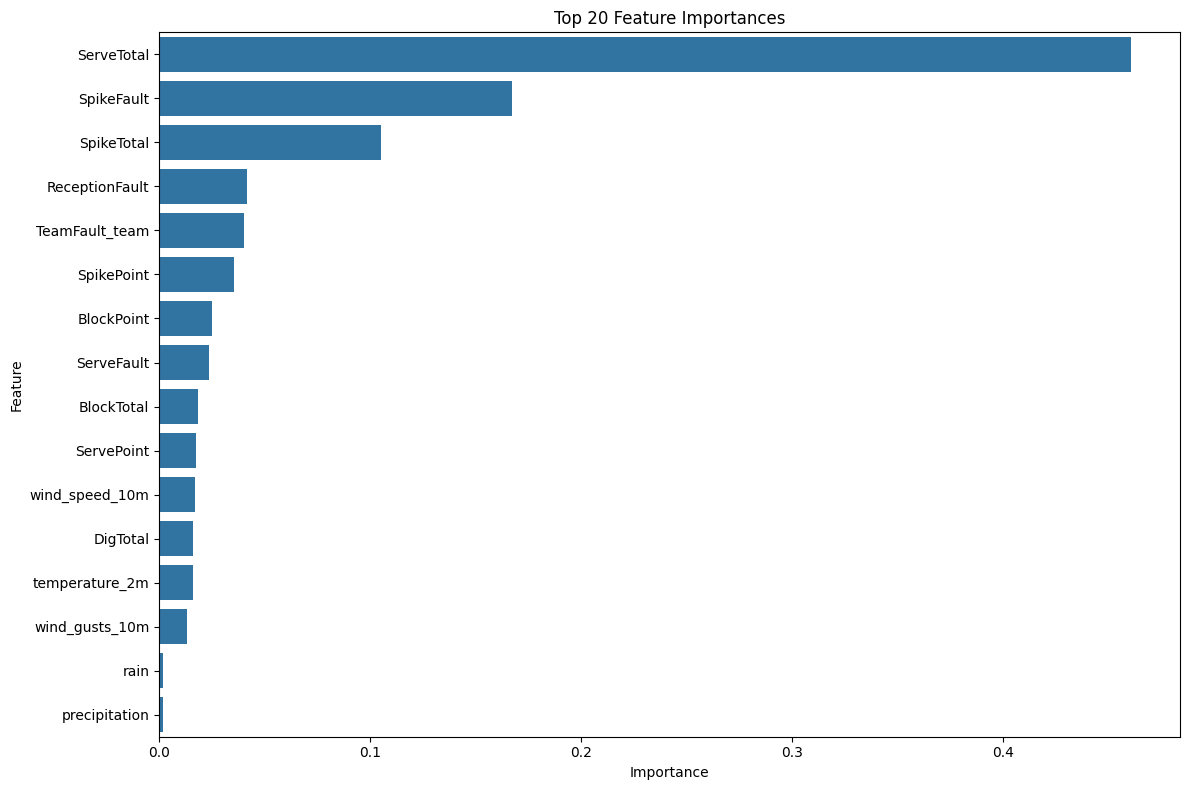

In [54]:
# Get feature importance from one of the tree-based models (e.g., Random Forest)
rf_model = trained_models['GradientBoosting']
preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend([f"{col}_{cat}" for col in cols 
                            for cat in ohe.categories_[cols.index(col)]])
    else:  # ordinal features
        feature_names.append(name[4:])  # Remove 'ord_' prefix

# Get and display feature importances
if hasattr(rf_model.named_steps['classifier'], 'feature_importances_'):
    importances = rf_model.named_steps['classifier'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Ensure lengths match
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()

In [76]:
# ==============================================
# Create Ensemble Model
# ==============================================
print("\nCreating ensemble model...")

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', Pipeline([('preprocessor', preprocessor), ('classifier', models['RandomForest'])])),
        ('gb', Pipeline([('preprocessor', preprocessor), ('classifier', models['GradientBoosting'])]))
    ],
    voting='soft'
)

# Evaluate voting classifier
voting_scores = cross_val_score(voting_clf, X, y, cv=cv, scoring='accuracy')
print(f"Voting Classifier - Cross-validation Accuracy: {voting_scores.mean():.4f} (±{voting_scores.std():.4f})")

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', Pipeline([('preprocessor', preprocessor), ('classifier', models['RandomForest'])])),
        ('gb', Pipeline([('preprocessor', preprocessor), ('classifier', models['GradientBoosting'])]))
    ],
    final_estimator=LogisticRegression(),
    cv=cv
)
# Evaluate stacking classifier
stacking_scores = cross_val_score(stacking_clf, X, y, cv=cv, scoring='accuracy')
print(f"Stacking Classifier - Cross-validation Accuracy: {stacking_scores.mean():.4f} (±{stacking_scores.std():.4f})")

# Train the ensemble model on the full training set
print("\nTraining final ensemble model on full dataset...")
stacking_clf.fit(X, y)


Creating ensemble model...
Voting Classifier - Cross-validation Accuracy: 0.8569 (±0.0068)


c:\Users\Katharina\Desktop\Weiterbildung\Bootcamp\Bootcamp\Final_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Katharina\Desktop\Weiterbildung\Bootcamp\Bootcamp\Final_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Katharina\Desktop\Weiterbildung\Bootcamp\Bootcamp\Final_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Katharina\Desktop\Weiterbildung\Bootcamp\Bootcamp\Final_project\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Katharina\Desktop\Weiterbildung\Bootcam

Stacking Classifier - Cross-validation Accuracy: 0.8573 (±0.0064)

Training final ensemble model on full dataset...


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rf',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   KNNImputer()),
                                                                                                  ('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['SpikeFault',
                                                                                   'SpikePoint',
                                                                                   'ServeFault',
                                                                                   'ServePoint',
                                                                                   'ServeTotal',
                                                                                   'BlockPoint',
                                                                                   'BlockTotal',
                                                                                   'DigTotal',
                                                                                   'Recepti...
                                                                                   'wind_speed_10m',
                                                                                   'rain',
                                                                                   'wind_gusts_10m',
                                                                                   'TeamFault_team']),
                                                                                 ('nom',
                                                                                  Pipeline(steps=[('imputer',
                                                                                                   SimpleImputer(strategy='most_frequent')),
                                                                                                  ('onehot',
                                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                                 sparse_output=False))]),
                                                                                  [])])),
                                                ('classifier',
                                                 GradientBoostingClassifier(max_depth=5,
                                                                            n_estimators=200,
                                                                            random_state=42,
                                                                            subsample=0.8))]))],
                   final_estimator=LogisticRegression())